In [1]:
from pandas import DataFrame, read_csv
from tqdm import tqdm

games_df = read_csv("./data/12-14-processed.csv")
games_df = games_df.dropna()

from sklearn.model_selection import train_test_split

feature_cols = [
    "PL5G",
    "OL5G",
    "PS",
    "OS",
    "PWR",
    "OWR",
    "AWR",
]

X = games_df[feature_cols]
y = games_df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

forest = RandomForestClassifier() 

forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

metrics.accuracy_score(y_test, y_pred)

0.9647825809063212

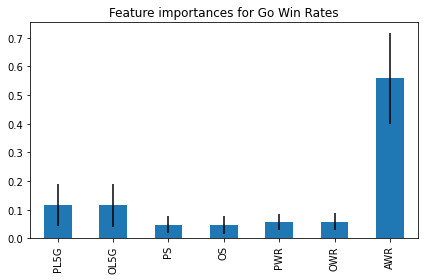

In [2]:
from pandas import Series
from matplotlib import pyplot
from numpy import std

std = std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = Series(forest.feature_importances_, index=feature_cols)

fig, ax = pyplot.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances for Go Win Rates")
fig.tight_layout()

In [3]:
metrics.confusion_matrix(y_test, y_pred)

array([[22567,   794],
       [  859, 22717]])